# 论文10：用于图像识别的深度残差学习
## Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun (2015)

### ResNet：跳跃连接使超深网络成为可能

ResNet 引入了残差连接，使得训练 100+ 层的网络成为可能。

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# 设置中文字体
plt.rcParams["font.family"] = ["Heiti TC"]
plt.rcParams["axes.unicode_minus"] = False

## 问题：深度网络的退化

在 ResNet 之前，增加更多层实际上会使网络性能变差（不是由于过拟合，而是优化困难）。

In [2]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

class PlainLayer:
    """标准神经网络层"""
    def __init__(self, input_size, output_size):
        self.W = np.random.randn(output_size, input_size) * np.sqrt(2.0 / input_size)
        self.b = np.zeros((output_size, 1))
    
    def forward(self, x):
        self.x = x
        self.z = np.dot(self.W, x) + self.b
        self.a = relu(self.z)
        return self.a
    
    def backward(self, dout):
        da = dout * relu_derivative(self.z)
        self.dW = np.dot(da, self.x.T)
        self.db = np.sum(da, axis=1, keepdims=True)
        dx = np.dot(self.W.T, da)
        return dx

class ResidualBlock:
    """带跳跃连接的残差块: y = F(x) + x"""
    def __init__(self, size):
        self.layer1 = PlainLayer(size, size)
        self.layer2 = PlainLayer(size, size)
    
    def forward(self, x):
        self.x = x
        
        # 残差路径 F(x)
        out = self.layer1.forward(x)
        out = self.layer2.forward(out)
        
        # 跳跃连接: F(x) + x
        self.out = out + x
        return self.out
    
    def backward(self, dout):
        # 梯度通过两条路径流动
        # 跳跃连接提供直接路径
        dx_residual = self.layer2.backward(dout)
        dx_residual = self.layer1.backward(dx_residual)
        
        # 总梯度: 残差路径 + 跳跃连接
        dx = dx_residual + dout  # 这是关键！
        return dx

print("ResNet components initialized")

ResNet components initialized


## 构建普通网络 vs ResNet

In [3]:
class PlainNetwork:
    """没有跳跃连接的普通深度网络"""
    def __init__(self, input_size, hidden_size, num_layers):
        self.layers = []
        
        # 第一层
        self.layers.append(PlainLayer(input_size, hidden_size))
        
        # 隐藏层
        for _ in range(num_layers - 2):
            self.layers.append(PlainLayer(hidden_size, hidden_size))
        
        # 输出层
        self.layers.append(PlainLayer(hidden_size, input_size))
    
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, dout):
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

class ResidualNetwork:
    """带残差连接的深度网络"""
    def __init__(self, input_size, hidden_size, num_blocks):
        # 投影到隐藏层大小
        self.input_proj = PlainLayer(input_size, hidden_size)
        
        # 残差块
        self.blocks = [ResidualBlock(hidden_size) for _ in range(num_blocks)]
        
        # 投影回输出
        self.output_proj = PlainLayer(hidden_size, input_size)
    
    def forward(self, x):
        x = self.input_proj.forward(x)
        for block in self.blocks:
            x = block.forward(x)
        x = self.output_proj.forward(x)
        return x
    
    def backward(self, dout):
        dout = self.output_proj.backward(dout)
        for block in reversed(self.blocks):
            dout = block.backward(dout)
        dout = self.input_proj.backward(dout)
        return dout

# 创建网络
input_size = 16
hidden_size = 16
depth = 10

plain_net = PlainNetwork(input_size, hidden_size, depth)
resnet = ResidualNetwork(input_size, hidden_size, depth)

print(f"Created Plain Network with {depth} layers")
print(f"Created ResNet with {depth} residual blocks")

Created Plain Network with 10 layers
Created ResNet with 10 residual blocks


## 演示梯度流

关键优势：梯度通过跳跃连接更容易流动

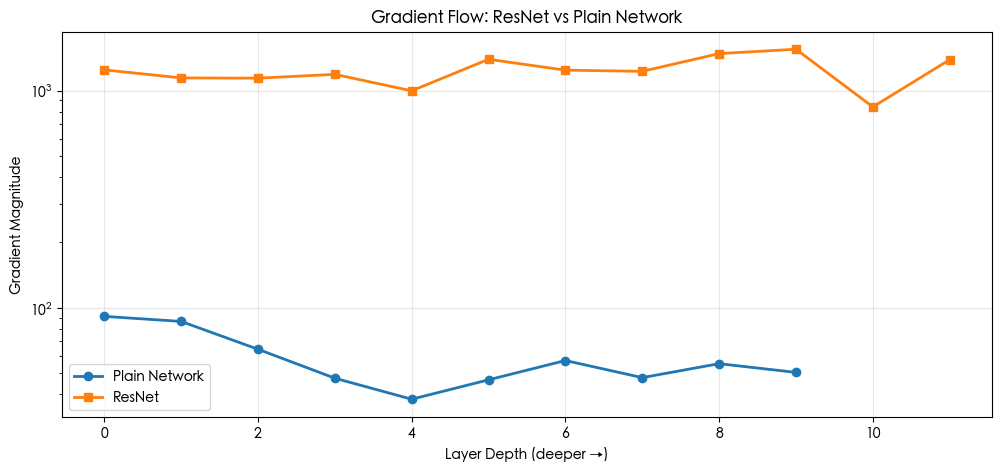


Plain Network - First layer gradient: 91.213143
Plain Network - Last layer gradient: 50.358035
Gradient ratio (first/last): 1.81x

ResNet - First layer gradient: 1245.176332
ResNet - Last layer gradient: 1386.924137
Gradient ratio (first/last): 0.90x

ResNet maintains gradient flow 2.0x better!


In [4]:
def measure_gradient_flow(network, name):
    """测量不同深度的梯度幅度"""
    # 随机输入
    x = np.random.randn(input_size, 1)
    
    # 前向传播
    output = network.forward(x)
    
    # 创建梯度信号
    dout = np.ones_like(output)
    
    # 反向传播
    network.backward(dout)
    
    # 收集梯度幅度
    grad_norms = []
    
    if isinstance(network, PlainNetwork):
        for layer in network.layers:
            grad_norm = np.linalg.norm(layer.dW)
            grad_norms.append(grad_norm)
    else:  # ResNet
        grad_norms.append(np.linalg.norm(network.input_proj.dW))
        for block in network.blocks:
            grad_norm1 = np.linalg.norm(block.layer1.dW)
            grad_norm2 = np.linalg.norm(block.layer2.dW)
            grad_norms.append(np.mean([grad_norm1, grad_norm2]))
        grad_norms.append(np.linalg.norm(network.output_proj.dW))
    
    return grad_norms

# 测量两个网络的梯度流
plain_grads = measure_gradient_flow(plain_net, "Plain Network")
resnet_grads = measure_gradient_flow(resnet, "ResNet")

# 绘制比较
plt.figure(figsize=(12, 5))
plt.plot(range(len(plain_grads)), plain_grads, 'o-', label='Plain Network', linewidth=2)
plt.plot(range(len(resnet_grads)), resnet_grads, 's-', label='ResNet', linewidth=2)
plt.xlabel('Layer Depth (deeper →)')
plt.ylabel('Gradient Magnitude')
plt.title('Gradient Flow: ResNet vs Plain Network')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

print(f"\nPlain Network - First layer gradient: {plain_grads[0]:.6f}")
print(f"Plain Network - Last layer gradient: {plain_grads[-1]:.6f}")
print(f"Gradient ratio (first/last): {plain_grads[0]/plain_grads[-1]:.2f}x\n")

print(f"ResNet - First layer gradient: {resnet_grads[0]:.6f}")
print(f"ResNet - Last layer gradient: {resnet_grads[-1]:.6f}")
print(f"Gradient ratio (first/last): {resnet_grads[0]/resnet_grads[-1]:.2f}x")

print(f"\nResNet maintains gradient flow {(plain_grads[0]/plain_grads[-1]) / (resnet_grads[0]/resnet_grads[-1]):.1f}x better!")

## 可视化学习到的表示

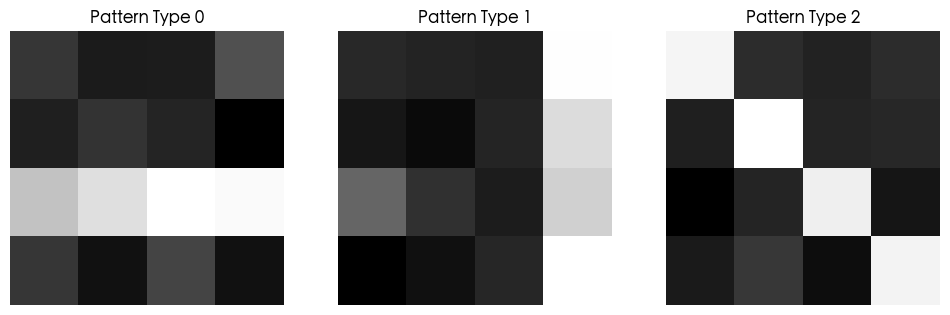

Generated 30 pattern samples


In [5]:
# 生成合成类图像数据
def generate_patterns(num_samples=100, size=8):
    """生成简单的 2D 模式"""
    X = []
    y = []
    
    for i in range(num_samples):
        pattern = np.zeros((size, size))
        
        if i % 3 == 0:
            # 水平线
            pattern[2:3, :] = 1
            label = 0
        elif i % 3 == 1:
            # 垂直线
            pattern[:, 3:4] = 1
            label = 1
        else:
            # 对角线
            np.fill_diagonal(pattern, 1)
            label = 2
        
        # 添加噪声
        pattern += np.random.randn(size, size) * 0.1
        
        X.append(pattern.flatten())
        y.append(label)
    
    return np.array(X), np.array(y)

X, y = generate_patterns(num_samples=30, size=4)

# 可视化样本模式
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, ax in enumerate(axes):
    sample = X[i].reshape(4, 4)
    ax.imshow(sample, cmap='gray')
    ax.set_title(f'Pattern Type {y[i]}')
    ax.axis('off')
plt.show()

print(f"Generated {len(X)} pattern samples")

## 恒等映射：核心洞察

**关键洞察**：如果恒等映射是最优的，残差应该学习 F(x) = 0，这比学习 H(x) = x 更容易

Identity Mapping Demonstration:
Input norm: 3.3237
Output norm: 3.3237
Identity error ||F(x) + x - x||: 0.000003

With near-zero weights, residual block ≈ identity function!


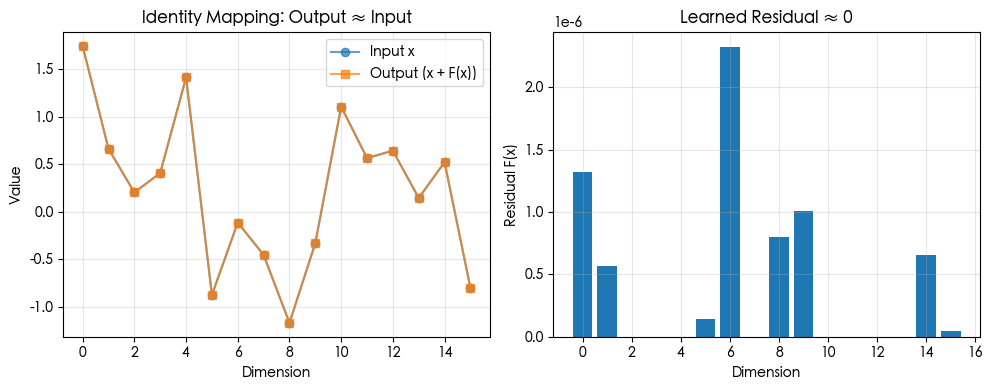

In [6]:
# 演示恒等映射
x = np.random.randn(hidden_size, 1)

# 初始化残差块
block = ResidualBlock(hidden_size)

# 如果权重接近零，F(x) ≈ 0
block.layer1.W *= 0.001
block.layer2.W *= 0.001

# 前向传播
output = block.forward(x)

# 检查输出是否 ≈ 输入（恒等）
identity_error = np.linalg.norm(output - x)

print("Identity Mapping Demonstration:")
print(f"Input norm: {np.linalg.norm(x):.4f}")
print(f"Output norm: {np.linalg.norm(output):.4f}")
print(f"Identity error ||F(x) + x - x||: {identity_error:.6f}")
print(f"\nWith near-zero weights, residual block ≈ identity function!")

# 可视化
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(x.flatten(), 'o-', label='Input x', alpha=0.7)
plt.plot(output.flatten(), 's-', label='Output (x + F(x))', alpha=0.7)
plt.xlabel('Dimension')
plt.ylabel('Value')
plt.title('Identity Mapping: Output ≈ Input')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
residual = output - x
plt.bar(range(len(residual)), residual.flatten())
plt.xlabel('Dimension')
plt.ylabel('Residual F(x)')
plt.title('Learned Residual ≈ 0')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 比较网络深度

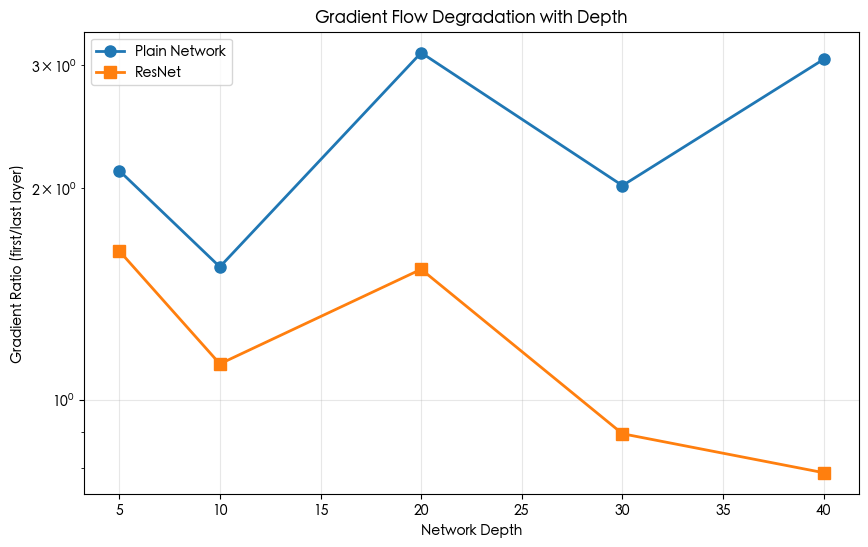


Gradient Ratio (first/last) - Higher = Worse gradient flow:
Depth  5: Plain=    2.12, ResNet=  1.63 (ResNet is 1.3x better)
Depth 10: Plain=    1.55, ResNet=  1.12 (ResNet is 1.4x better)
Depth 20: Plain=    3.12, ResNet=  1.53 (ResNet is 2.0x better)
Depth 30: Plain=    2.02, ResNet=  0.89 (ResNet is 2.3x better)
Depth 40: Plain=    3.05, ResNet=  0.79 (ResNet is 3.9x better)


In [7]:
def test_depth_scaling():
    """测试梯度流如何随深度变化"""
    depths = [5, 10, 20, 30, 40]
    plain_ratios = []
    resnet_ratios = []
    
    for depth in depths:
        # 创建网络
        plain = PlainNetwork(input_size, hidden_size, depth)
        res = ResidualNetwork(input_size, hidden_size, depth)
        
        # 测量梯度
        plain_grads = measure_gradient_flow(plain, "Plain")
        res_grads = measure_gradient_flow(res, "ResNet")
        
        # 计算比率（第一层/最后一层梯度）
        plain_ratio = plain_grads[0] / (plain_grads[-1] + 1e-10)
        res_ratio = res_grads[0] / (res_grads[-1] + 1e-10)
        
        plain_ratios.append(plain_ratio)
        resnet_ratios.append(res_ratio)
    
    # 绘制
    plt.figure(figsize=(10, 6))
    plt.plot(depths, plain_ratios, 'o-', label='Plain Network', linewidth=2, markersize=8)
    plt.plot(depths, resnet_ratios, 's-', label='ResNet', linewidth=2, markersize=8)
    plt.xlabel('Network Depth')
    plt.ylabel('Gradient Ratio (first/last layer)')
    plt.title('Gradient Flow Degradation with Depth')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    plt.show()
    
    print("\nGradient Ratio (first/last) - Higher = Worse gradient flow:")
    for i, d in enumerate(depths):
        print(f"Depth {d:2d}: Plain={plain_ratios[i]:8.2f}, ResNet={resnet_ratios[i]:6.2f} "
              f"(ResNet is {plain_ratios[i]/resnet_ratios[i]:.1f}x better)")

test_depth_scaling()

## 关键要点

### 退化问题：
- 向普通网络添加更多层会损害性能
- **不是**由于过拟合（训练误差也会增加）
- 由于优化困难：梯度消失/爆炸

### ResNet 解决方案：跳跃连接
```
y = F(x, {Wi}) + x
```

**不是学习**：H(x) = 期望映射  
**学习残差**：F(x) = H(x) - x  
**然后**：H(x) = F(x) + x

### 为什么有效：
1. **恒等映射更容易**：如果最优映射是恒等，学习 F(x) = 0 比学习 H(x) = x 更容易
2. **梯度高速公路**：跳跃连接提供直接的梯度路径
3. **加性梯度流**：梯度通过残差和跳跃两条路径流动
4. **无额外参数**：跳跃连接是无参数的

### 影响：
- 使 152 层网络成为可能（之前限制为 20 层）
- 赢得 ImageNet 2015（3.57% top-5 误差）
- 成为标准架构模式
- 启发了变体：DenseNet、ResNeXt 等

### 数学洞察：
损失 L 对较早层的梯度：
```
∂L/∂x = ∂L/∂y * (∂F/∂x + ∂x/∂x) = ∂L/∂y * (∂F/∂x + I)
```
`+ I` 项确保梯度始终流动！